In [1]:
#Load the libraries
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, UpSampling2D
from keras.layers.merge import concatenate
from tensorflow.nn import local_response_normalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
import pickle
from datetime import datetime
from numba import cuda 

%matplotlib inline

In [3]:
import sys  
sys.path.insert(0, '..')

In [4]:
from tiling.read_tiles_with_mask import TissueDataset, load_color_normalization_values

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
dim_tiles = 256
depth = 3

In [7]:
def unet(layer_in = Input(shape=(dim_tiles, dim_tiles, depth))):
    inputs = layer_in
    
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(inputs) #dilation_rate=2 etc.
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(conv1) #dilation_rate=2 etc.
    # conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    # conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    # conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    # conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    # conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5) 

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8) 

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [8]:
model = unet()

In [9]:
HDF5_FOLDER = '/media/nico/data/fourthbrain/project/training_CAMELYON16'

In [10]:
color_normalization_json = "CAMELYON16_color_normalization.json"

In [11]:
log_dir = "/media/nico/data/fourthbrain/project/unet_testing/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [18]:
train_data = TissueDataset(HDF5_FOLDER,  percentage=0.8, first_part=True, crop_size=256)
val_data = TissueDataset(HDF5_FOLDER, percentage=0.2, first_part=False, crop_size=256)

/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_090_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_091_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_091_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_092_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_092_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_093_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_093_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_094_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_094_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_095_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/p

/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_090_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_091_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_091_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_092_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_092_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_093_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_093_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_094_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_094_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_095_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/p

/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_029_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_018_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_019_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_019_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_020_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_020_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_021_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_021_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_022_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthbrain/project/training_CAMELYON16/tumor_022_masks_312x312_poi0.4_level3.hdf5
/media/nico/data/fourthb

In [40]:
a, b = train_data.get_batch()

In [41]:
a.shape

(10, 256, 256, 3)

In [42]:
a[:, :, :, 1] = 1

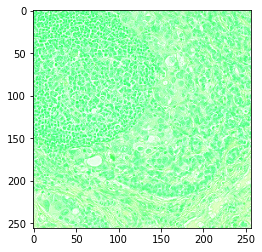

In [43]:
plt.imshow(a[0])

In [ ]:
batch_size=10
batches_per_train_epoch = 10
batches_per_val_epoch = 10
MAX_EPOCHS = 100

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.generator(batch_size, True, green_layer_only=False, color_normalization_file=color_normalization_json),
                    validation_data=val_data.generator(batch_size, False, green_layer_only=False, color_normalization_file=color_normalization_json),
                    epochs=MAX_EPOCHS,
                    steps_per_epoch = batches_per_train_epoch,
                    validation_steps = batches_per_val_epoch)

In [ ]:
# now1 = datetime.now()
# model_type = 'unet'
# model_hdf5 = '/media/nico/data/fourthbrain/project/model_testing/model_{}_'.format(model_type) + now1.strftime("%Y%m%d-%H%M%S") + '.hdf5'
# filepath = '/media/nico/data/fourthbrain/project/model_testing/{}.pkl'.format(model_type)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_hdf5, monitor='loss',verbose=1, save_best_only=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
#                            verbose=1, mode='max', min_lr=1e-5)

# #all callbacks
# callbacks = [tensorboard_callback, model_checkpoint, reduce_lr]        
# history = model.fit(train_data.generator(batch_size_neg, batch_size_pos, True, green_layer_only=False, color_normalization_file=color_normalization_json),
#                     validation_data=val_data.generator(batch_size_neg, batch_size_pos, False, green_layer_only=False, color_normalization_file=color_normalization_json),
#                     epochs=MAX_EPOCHS,
#                     steps_per_epoch = batches_per_train_epoch,
#                     validation_steps = batches_per_val_epoch,
#                     callbacks=callbacks
#                    )
# dtme = now1.strftime('%m%d%Y_%H%M%S.pkl')
# now2 = datetime.now()
# print('duration: {} - path: {}'.format(now2 - now1, filepath))
# history_to_pickle(history, filepath)

In [15]:
f = "/media/nico/data/fourthbrain/project/training_CAMELYON16/old/tumor_001_312x312_poi0.4_level3.hdf5"
import h5py

In [16]:
data_file = h5py.File(f, 'r', libver='latest', swmr=True)


OSError: Unable to open file (unable to open file: name = '/media/nico/data/fourthbrain/project/training_CAMELYON16/old/tumor_001_312x312_poi0.4_level3.hdf5', errno = 2, error message = 'No such file or directory', flags = 40, o_flags = 0)

In [ ]:
key = list(data_file.keys())[0]

In [ ]:
a = data_file[key]

In [ ]:
for x in a:
    print(x.shape)
    

In [ ]:
a[0].shape